# Polarized Propagation
This is a brief how-to on how to use prysm's polarized propagation feature. Users should already be familiar with [Jones Calculus](../tutorials/Jones-Calculus.ipynb), and the [First Diffraction Model](../tutorials/First-Diffraction-Model.ipynb) before going through this how-to. 

When we step outside of the classroom and into the laboratory, we discover that things are not always perfect. In an ideal world, a polarizer is a perfect polarizer, and the degree to which it polarizes doesn't change across the optic. In reality, manufacturing defects can complicate our optical system by introducing unwanted effects. In this how-to, we cover how `prysm` can help you model spatially-varying polarization optics in diffraction problems with polarized field propagation.

We begin with a simple extension of the Jones Matrix $\mathbf{J}$ into the spatial domain:

$$
\mathbf{J}(x,y) =
\begin{pmatrix}
J_{xx}(x,y) & J_{xy}(x,y) \\
J_{yx}(x,y) & J_{yy}(x,y) \\
\end{pmatrix}
$$

All this means is that we consider $\mathbf{J}$ to be a function that varies with position across a given optical element. In `prysm`, polarization-modifying components are simply arrays of dimension `(M,N,2,2)`, which allows their effect to vary spatially, as shown for the case of a linear retarder below.

In [1]:
from prysm.x.polarization import linear_retarder
import numpy as np

retarder = (linear_retarder(retardance=np.pi/2,theta=0,shape=[256,256]))
print(retarder.shape)

(256, 256, 2, 2)


Any shape `(M,N,2,2)` complex array can be used as a polarization component.  `x/polarization` contains a function that generates a vector vortex retarder (VVR), a component that is like an azimuthally-varying half wave plate. VVRs allow us to do some really interesting things with light. However for the purposes of this demo, we use it simply to illustrate spatially-varying polarized elements with `prysm`. 

In [14]:
import matplotlib.pyplot as plt

# Initialize a plotting macro
def plot_jones_matrix(J,title='blank title'):
    k = 1

    plt.figure()
    plt.suptitle(title)
    for i in range(2):
        for j in range(2):
            plt.subplot(2,2,k)
            plt.imshow(J[...,i,j],vmin=-np.pi,vmax=np.pi)
            plt.colorbar()
            k += 1
    plt.show()

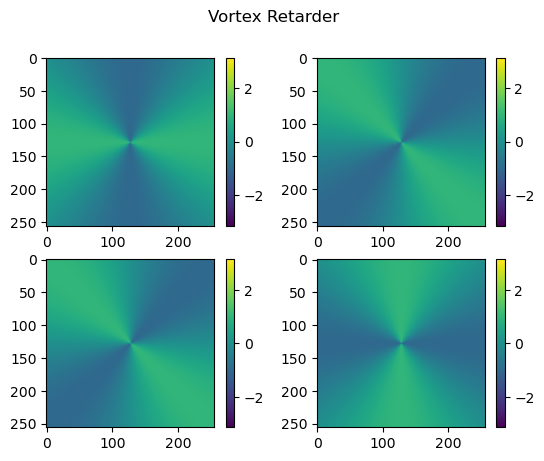

In [15]:
from prysm.coordinates import make_xy_grid,cart_to_polar
from prysm.x.polarization import vector_vortex_retarder

# Generate the VVR, a spatially-varying half-wave plate
vvr = vector_vortex_retarder(2,256,retardance=np.pi)
plot_jones_matrix(np.real(vvr),title='Vortex Retarder')

Now we will put this VVR in front of a perfect lens with a circular aperture to see how this spatially-varying retardance affects image formation. However, to make `prysm.propagation` compatible with polarized fields we need to call `add_jones_propagation` from `x/polarization`.

In [4]:
from prysm.x.polarization import add_jones_propagation
add_jones_propagation()

The propagation functions that presently support polarized propagation are included in the `supported_propagation_funcs` list in `x/polarization`

In [5]:
from prysm.x.polarization import supported_propagation_funcs
print('supported propagation functions = ',supported_propagation_funcs)

supported propagation functions =  ['focus', 'unfocus', 'focus_fixed_sampling', 'angular_spectrum']


`add_jones_propagation` goes through the supported `prysm.propagation` functions and applies a decorator to them to support propagation of `shape` $\times$ 2 $\times$ 2 arrays. We can then go and load in a propagation function to examine the PSF. 

Note that because of the shape required for the matrix multiplication that Jones matrices need, we cannot simply multiply the aperture array `A` by the VVR jones matrix `vvr`. To make this easier, we've added the `apply_polarization_to_field` function that extends the dimensions of scalar field arrays to match the Jones matrix arrays so that they support element-wise multiplication.

In [12]:
from prysm.propagation import focus_fixed_sampling
from prysm.geometry import circle
from prysm.x.polarization import apply_polarization_to_field

def propagate(wf):
    wfout = focus_fixed_sampling(wf,
                                 input_dx=5e3/256,
                                 prop_dist=50e3,
                                 wavelength=1,
                                 output_dx=10e-1,
                                 output_samples=256)
    return wfout

x,y = make_xy_grid(256,diameter=1)
r,t = cart_to_polar(x,y)

# set up a circular aperture and propagate
A = circle(0.5,r)
a_ref = propagate(A)

#  multiply A by the polarizing element
A = apply_polarization_to_field(A) 
j_out = propagate(vvr*A)

To visualize this in irradiance, we need to compute the Mueller matrix from the Jones matrix `j_out`. We can use `jones_to_mueller` to do this rapidly. The [0,0] element of the resultant Mueller matrix represents the response of the optical system to unpolarized light. Below we compare the focal plane irradiances for imaging with a circular aperture (left) and imaging with a circular aperture with a vortex phase (right). The phase of the vortex is such that the on-axis irradiance completely cancels.

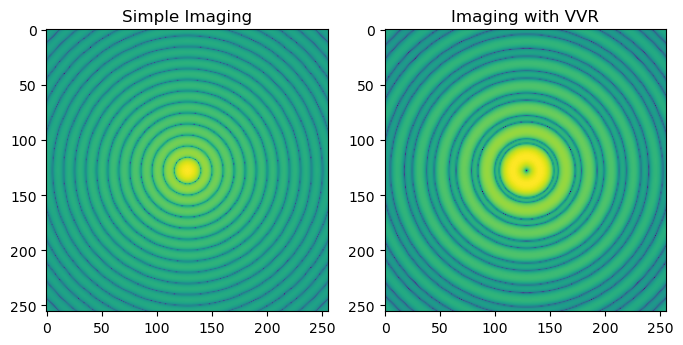

In [17]:
from prysm.x.polarization import jones_to_mueller

m_out  = jones_to_mueller(j_out, broadcast=True)
intensity_from_scalar = np.abs(a_ref)**2
intensity_from_mueller = m_out[..., 0, 0]

plt.figure(figsize=[8,4])
plt.subplot(121)
plt.title('Simple Imaging')
plt.imshow(np.log10(intensity_from_scalar))
plt.subplot(122)
plt.title('Imaging with VVR')
plt.imshow(np.log10(intensity_from_mueller))
plt.show()

In summary, `x/polarization` enables numerical propagation through optical elements that can be represented as a Jones matrix. These elements are arrays of matrices whose row and column indices are in the last two dimensions of the array. This can be applied to problems that involve optical elements like VVRs, which require polarization for a complete description.